In [1]:
import lecilab_behavior_analysis.utils as utils
import lecilab_behavior_analysis.df_transforms as dft
import lecilab_behavior_analysis.plots as plots
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import time
import datetime


%load_ext autoreload
%autoreload 2

In [2]:
project = "visual_and_COT_data"
animals=['ACV001', 'ACV002', 'ACV003', 'ACV004', 'ACV005', 'ACV006', 'ACV007', 'ACV008', 'ACV009', 'ACV010']
df_list = []
for mouse in animals:
    local_path = Path(utils.get_outpath()) / Path(project) / Path("sessions") / Path(mouse)
    df = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")
    df_list.append(df)
    print(f"Loaded data for {mouse}.")
# concatenate the dataframes
df = pd.concat(df_list, ignore_index=True)
clear_output(wait=True)
time.sleep(.5)
print("Data read successfully.")

Data read successfully.


In [34]:
# restrict analysis to multisensory sessions, both modalities
df_subset = df[df["current_training_stage"] == "TwoAFC_multisensory_easy"]

In [35]:
df_subset = dft.analyze_df(df_subset)

In [36]:
# Port 2 was sometimes faulty. Eliminate trials that have many Port2Ins in order to reduce complexity as well
limit_of_entries = 7
port2counts = df_subset.Port2In.apply(lambda x: len(eval(x)))
df_subset = df_subset[port2counts <= limit_of_entries]

In [37]:
# there is something weird in some trials, probably due to the faulty port2.
# sometimes, there is a port entry that follows another port entry without a port exit in between.
# sometimes, there is a port exit that follows another port event without an entry in that port.

def detect_weird_port_events_sequence(events):
    events = eval(events)
    # filter only port events
    events = [event for event in events if event in ['Port1In', 'Port1Out', 'Port2In', 'Port2Out', 'Port3In', 'Port3Out']]
    # Ins need to be followed by their corresponding Outs
    # Outs need to be followed by any In
    for i in range(1, len(events) - 1):
        match events[i]:
            case 'Port1In':
                if events[i + 1] != 'Port1Out':
                    return True
            case 'Port2In':
                if events[i + 1] != 'Port2Out':
                    return True
            case 'Port3In':
                if events[i + 1] != 'Port3Out':
                    return True
            case 'Port1Out' | 'Port2Out' | 'Port3Out':
                if events[i + 1] not in ['Port1In', 'Port2In', 'Port3In']:
                    return True
    return False

In [38]:
weird_sequences = df_subset.ordered_list_of_events.apply(detect_weird_port_events_sequence)

In [39]:
# remove these trials from the dataframe
df_subset = df_subset[~weird_sequences]

The % of fixation breaks on incorrect trials is higher, indicating that they don't have this urge to respond:

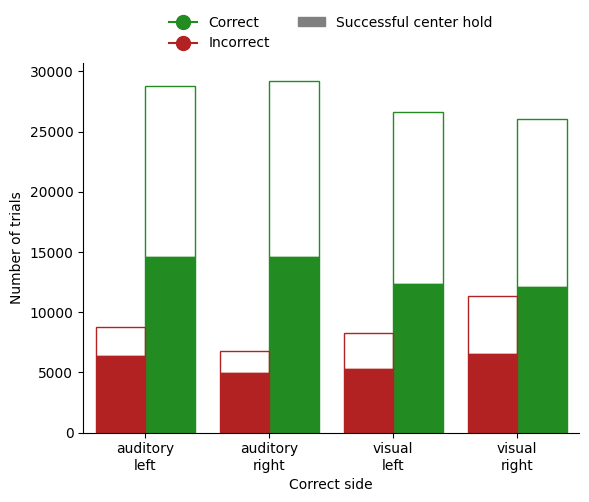

In [40]:
plots.number_of_correct_responses_plot(df_subset)
plt.show()

In [10]:
# use the same colors for other plots:
colors = {
    True: "forestgreen",
    False: "firebrick",
    'correct_trials': 'forestgreen',
    'incorrect_trials': 'firebrick',
}

In [41]:
# quantify the difference in early pokeouts between correct and incorrect trials
print("Resulting in incorrect trials:")
print(100*df_subset[df_subset.correct == False].early_pokeout.value_counts(normalize=True))
print("Resulting in correct trials:")
print(100*df_subset[df_subset.correct == True].early_pokeout.value_counts(normalize=True))

Resulting in incorrect trials:
early_pokeout
False    65.815033
True     34.184967
Name: proportion, dtype: float64
Resulting in correct trials:
early_pokeout
True     51.580516
False    48.419484
Name: proportion, dtype: float64


Question 1. Do they poke on the side ports after breaking fixation?

1.1. How long do they take to poke back in center after breaking fixation?

1.2. Does this differ between correct and incorrect trials?

1.3. Is this usually the correct port?

1.4. Do they change their mind at some point?

1.5. Do they understand the information about the center light port turning off?

1.6. When there are multiple fixation breaks, does waiting time increase or decrease?

1.7. Are these breaks distributed equally along a session?

In [42]:
# 1.2. An incorrect hold shows as a sequence: 'Port2In', 'Tup', 'Port2Out' , or 'Port2In', 'Port2Out'
# (a correct one is 'Port2In', 'Tup', 'Tup', 'Port2Out')
# get the next event after these sequences

def detect_incorrect_hold_and_next_event(events):
    incorrect_hold_sequence_one = ['Port2In', 'Tup', 'Port2Out']
    incorrect_hold_sequence_two = ['Port2In', 'Port2Out']
    correct_hold_sequence = ['Port2In', 'Tup', 'Tup', 'Port2Out']
    next_events = []
    events = eval(events)
    # remove all events after a correct hold
    for i in range(len(events) - 3):
        if events[i:i+4] == correct_hold_sequence:
            events = events[:i+4]
            break
    for i in range(len(events) - 2):
        if events[i:i+3] == incorrect_hold_sequence_one:
            if i + 3 < len(events):
                next_events.append(events[i + 3])
        elif events[i:i+2] == incorrect_hold_sequence_two:
            if i + 2 < len(events):
                next_events.append(events[i + 2])
    return next_events

In [43]:
df_subset["next_event_after_fixation_break"] = df_subset["ordered_list_of_events"].apply(detect_incorrect_hold_and_next_event)

In [44]:
# transform the next_event_after_fixation_break column to a more usable format: 'correct_side', 'incorrect_side', 'center'
def classify_next_events(next_events, correct_side):
    classifications = []
    for event in next_events:
        if event == 'Port1In':
            if correct_side == 'left':
                classifications.append('correct_side')
            else:
                classifications.append('incorrect_side')
        elif event == 'Port3In':
            if correct_side == 'right':
                classifications.append('correct_side')
            else:
                classifications.append('incorrect_side')
        elif event == 'Port2In':
            classifications.append('center')
        else:
            pass  # ignore other events
    return classifications

In [45]:
df_subset["next_event_after_fixation_break_classified"] = df_subset.apply(
    lambda row: classify_next_events(row["next_event_after_fixation_break"], row["correct_side"]), axis=1
)

In [46]:
# how long do these fixation take and is this related with the kind of poke they do after?
df_subset["port2_holds"] = df_subset.apply(lambda row: utils.get_trial_port_hold(row, 2), axis=1)

In [47]:
# count occurrences of each classification in total
fb_dict = {
    'trial_correct': [],
    'hold_length': [],
    'break_to_port': [],
    'modality': [],
}

for ports_after_break, correct, hold_lengths, index, early_pokeout, holding_time, modality in zip(
    df_subset["next_event_after_fixation_break_classified"], df_subset["correct"],
    df_subset["port2_holds"], df_subset.index, df_subset["early_pokeout"], df_subset["holding_time"],
    df_subset["stimulus_modality"],
    ):
    # filter using "early_pokeout" column, as this takes on account cases where the animal initiate
    # pokes before the ready_to_initiate BPOD states, and can result in misleading hold lengths
    # though this is not perfect either, as this can still happen, and then the mouse can still do a
    # fixation break. This very rare though. I found only 1 case in 73618 trials.
    if not early_pokeout:
        continue
    if hold_lengths[0] >= holding_time:
        continue
    for i, port in enumerate(ports_after_break):
        fb_dict['trial_correct'].append(correct)
        fb_dict['hold_length'].append(hold_lengths[i])
        fb_dict['break_to_port'].append(port)
        fb_dict['modality'].append(modality)
fb_df = pd.DataFrame(fb_dict)
# group by break_to_port and trial_correct, get mean and count of hold_length
fb_df_gb = fb_df.groupby(['break_to_port', 'trial_correct', 'modality']).agg(['mean', 'std', 'count']).reset_index()
fb_df_gb.columns = ['break_to_port', 'trial_correct', 'modality', 'hold_length_mean', 'hold_length_std', 'hold_length_count']
# print(fb_df_gb)

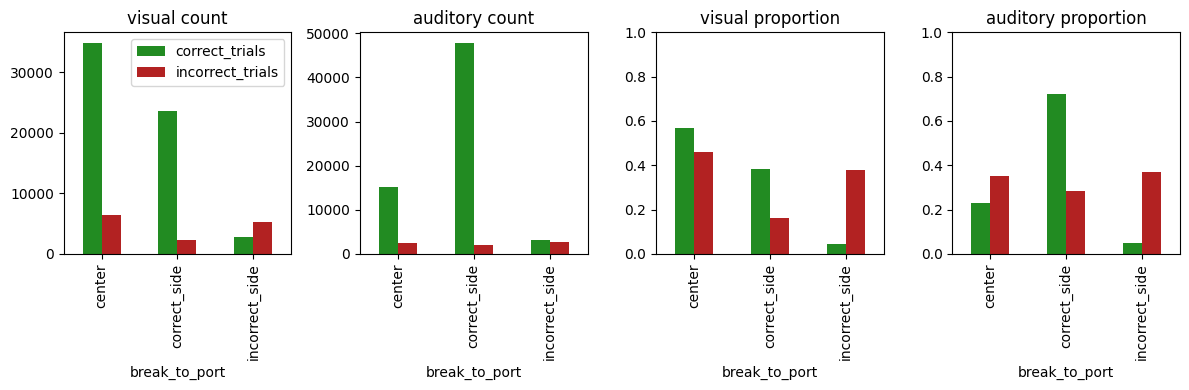

In [55]:
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
ax_counter = 0
for modality in fb_df['modality'].unique():
    fb_df_modality = fb_df[fb_df['modality'] == modality]
    classification_df = pd.DataFrame({
        'correct_trials': fb_df_modality[fb_df_modality.trial_correct == True].break_to_port.value_counts(),
        'incorrect_trials': fb_df_modality[fb_df_modality.trial_correct == False].break_to_port.value_counts()
    }).fillna(0)
    # transform to proportions
    classification_df_prop = classification_df.div(classification_df.sum(axis=0), axis=1)
    # make bar plots, side by side
    classification_df.plot.bar(ax=axs[ax_counter], color=colors, title=f'{modality} count')
    classification_df_prop.plot.bar(ax=axs[ax_counter+2], color=colors, title=f'{modality} proportion')
    ax_counter += 1
for ax in axs[1:]:
    ax.legend_.remove()
for ax in axs[2:]:
    ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

In [19]:
# TODO: do this per mouse/session to get stats

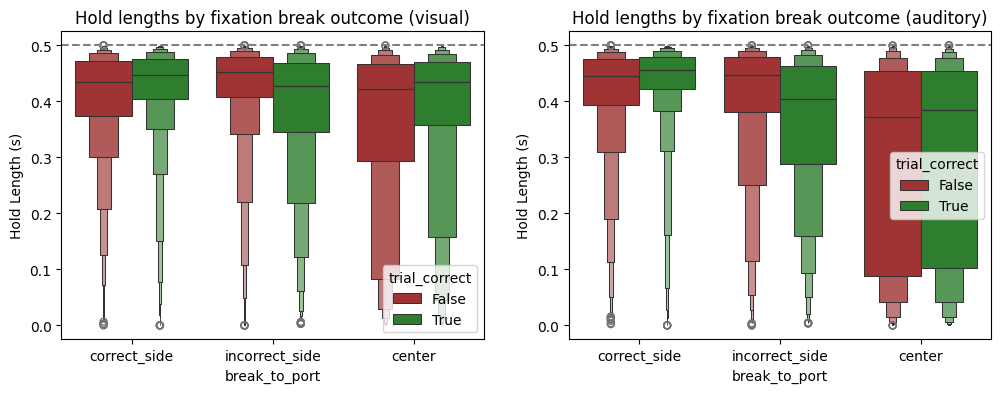

In [57]:
# hold lengths plot
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for modality, ax in zip(fb_df['modality'].unique(), axs):
    sns.boxenplot(
        data=fb_df[fb_df['modality'] == modality],
        x='break_to_port',
        y='hold_length',
        hue='trial_correct',
        # errorbar=('pi', 50),
        # dodge=True,
        ax=ax,
        palette=colors
    )
    # horizontal line at 0.5 s
    ax.axhline(0.5, color='grey', linestyle='--', label='Required Hold Time (0.5s)')
    ax.set_title(f'Hold lengths by fixation break outcome ({modality})')
    ax.set_ylabel('Hold Length (s)')
# ax.set_ylim(0, ax.get_ylim()[1])
plt.show()

In [58]:
# look at the distribution of holding time for all ports
df_subset["port3_holds"] = df_subset.apply(lambda row: utils.get_trial_port_hold(row, 3), axis=1)
df_subset["port1_holds"] = df_subset.apply(lambda row: utils.get_trial_port_hold(row, 1), axis=1)

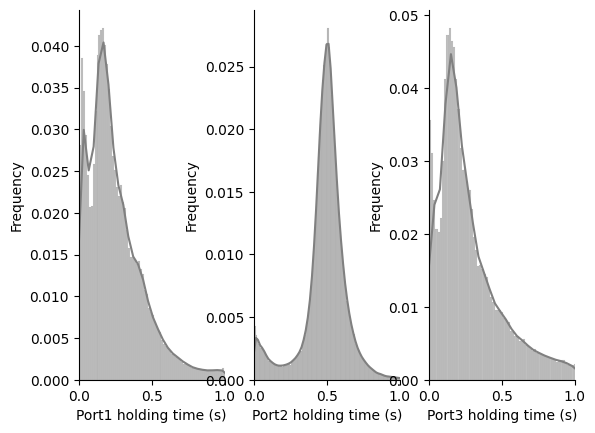

In [59]:
fig, axs = plt.subplots(1,3)
axs = axs.ravel()
for i in range(1,4):
    plots.plot_port_holding_time_histogram(df_subset, port_number=i, ax=axs[i-1], bins=500)
    # set x limit to 1 second
    axs[i-1].set_xlim(0, 1)
plt.show()

All ports show these fast holding times

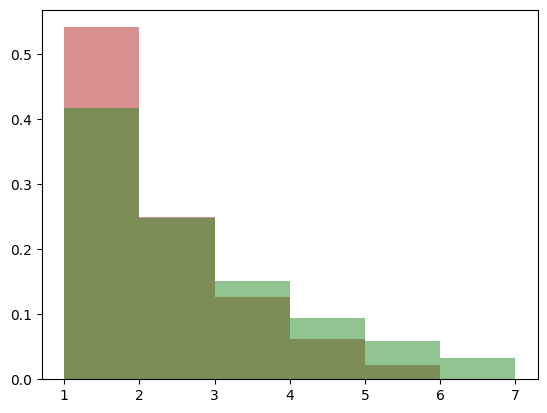

In [60]:
# how many fixation breaks are there depending on the final choice?
fb_dist_correct = df_subset[df_subset["correct"] == True]["next_event_after_fixation_break_classified"].apply(len)
fb_dist_incorrect = df_subset[df_subset["correct"] == False]["next_event_after_fixation_break_classified"].apply(len)
# remove 0s
fb_dist_correct = fb_dist_correct[fb_dist_correct > 0]
fb_dist_incorrect = fb_dist_incorrect[fb_dist_incorrect > 0]
plt.hist(fb_dist_incorrect, bins=range(1, 8), alpha=.5, color='firebrick', density=True)
plt.hist(fb_dist_correct, bins=range(1, 8), alpha=.5, color='forestgreen', density=True)
plt.show()


#### Key observations, though this is mixing all events together, so if a trial has multiple fixation breaks, they all count:
- In incorrect trials, they choose more or less equally.
- In correct trials, they are more likely to poke in the correct side port after breaking fixation, pointing at urges to respond (more fixation breaks per trial in these cases)
- In incorrect trials, 1/3 of fixation breaks are followed by poking in the correct side port, which might indicate that animals think it was wrong (does this influence the next trials? do animals update their belief here?)
- Animals are likely to recognize that a fixation break was premature, as they don't try poking in the side when they move too early.

### How are fixation breaks distributed over sessions?

In [61]:
# clean the column from trials where mouse can poke in center port before stimulus comes in and that type of thing
def get_clean_number_of_fixation_breaks(series):
    number_of_fixation_breaks = len(series.next_event_after_fixation_break)
    if not series.early_pokeout:
        number_of_fixation_breaks = 0
    elif series.port2_holds[0] >= series.holding_time:
        number_of_fixation_breaks = 0
    return number_of_fixation_breaks
df_subset["number_of_fixation_breaks"] = df_subset.apply(get_clean_number_of_fixation_breaks, axis=1)

In [62]:
# select a random session and plot the fixation breaks over trials
random_sessions = df_subset[df_subset.subject == "ACV001"].date.sample(15).values
random_sessions.sort()

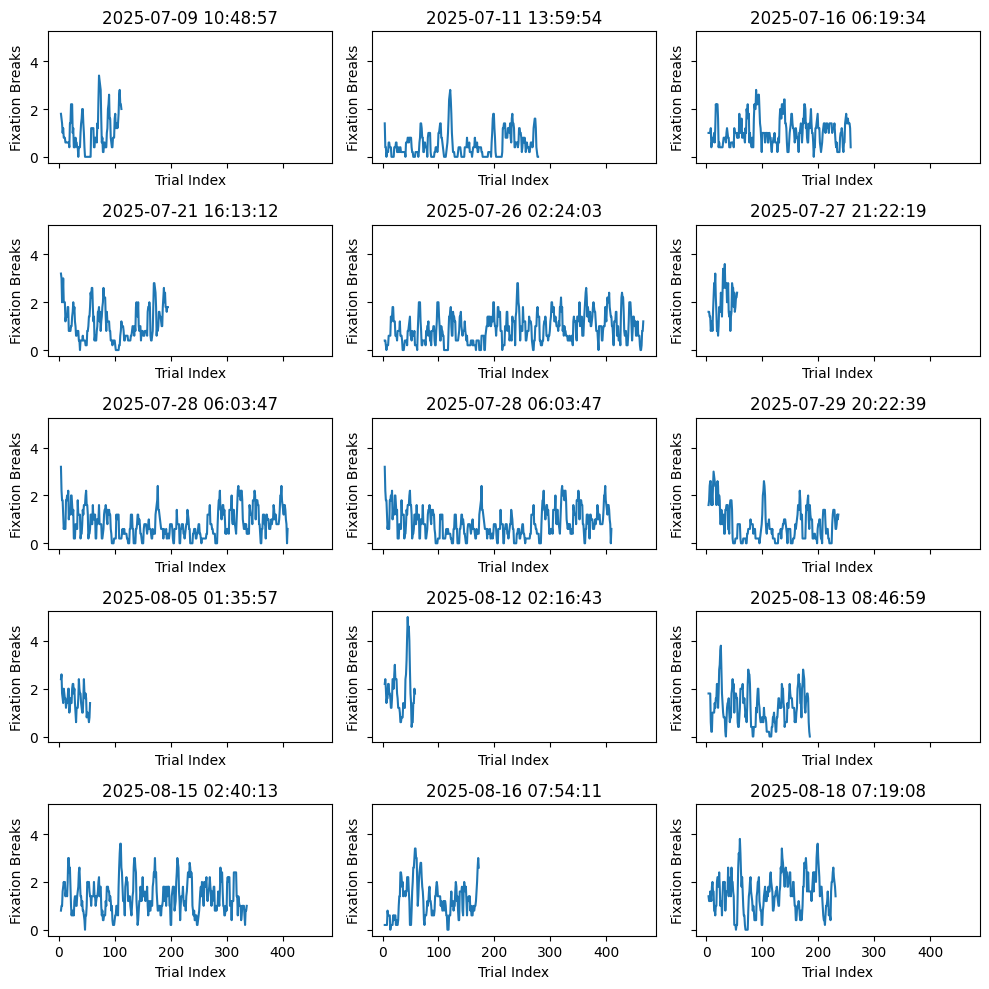

In [63]:
fig, axs = plt.subplots(5,3,figsize=(10, 10), sharex=True, sharey=True)
axs = axs.ravel()
for i, random_session in enumerate(random_sessions):
    df_session = df_subset[df_subset.date == random_session]
    # smooth the number_of_fixation_breaks using a rolling window of 5 trials
    fb_smooth = df_session["number_of_fixation_breaks"].rolling(window=5).mean()
    axs[i].plot(
        range(len(fb_smooth)),
        fb_smooth,
        # c=df_session["correct"].map(colors),
    )
    axs[i].set_xlabel("Trial Index")
    axs[i].set_ylabel("Fixation Breaks")
    axs[i].set_title(f"{random_session}")
plt.tight_layout()
plt.show()


In [64]:
# is there a correlation between number of fixation breaks and performance?
window = 5
for date in df_subset.date.unique():
    # find indexes for that date
    idx = df_subset.date == date
    df_subset.loc[idx, "performance_w"] = dft.get_performance_through_trials(df_subset.loc[idx, :], window=window).performance_w
    # smooth number_of_fixation_breaks
    df_subset.loc[idx, "fixation_breaks_through_trials"] = df_subset.loc[idx, "number_of_fixation_breaks"].rolling(window=window).mean()

In [ ]:
# compute the correlation between performance_w and fixation_breaks_through_trials
correlations = []
dates = []
number_of_trials = []
for date in df_subset.date.unique():
    idx = df_subset.date == date
    corr = df_subset.loc[idx, ["performance_w", "fixation_breaks_through_trials"]].corr().iloc[0,1]
    correlations.append(corr)
    dates.append(date)
    number_of_trials.append(idx.sum())

corr_df = pd.DataFrame({
    'date': dates,
    'correlation': correlations,
    'number_of_trials': number_of_trials
})

In [66]:
ntrial_threshold = 75
corr_df['ntrials_bin'] = corr_df['number_of_trials'] >= ntrial_threshold

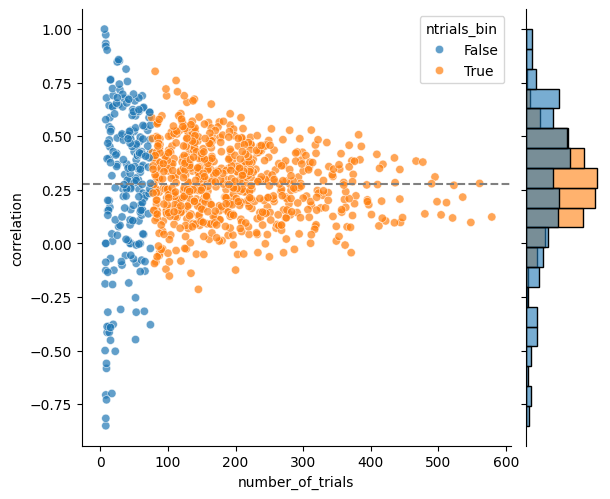

In [69]:
g = sns.JointGrid(
    data=corr_df,
    x="number_of_trials",
    y="correlation",
    hue="ntrials_bin",
)

# Central scatter
g.plot_joint(
    sns.scatterplot,
    alpha=0.7
)

# add a horizontal line at the mean
g.ax_joint.axhline(corr_df['correlation'].mean(), color='grey', linestyle='--', label='Mean Correlation')

# Marginal histograms (relative)
g.plot_marginals(
    sns.histplot,
    stat="density",      # or "probability"
    common_norm=False,
    bins=20,
    alpha=0.6
)

# remove the top marginal
g.ax_marg_x.remove()
plt.show()

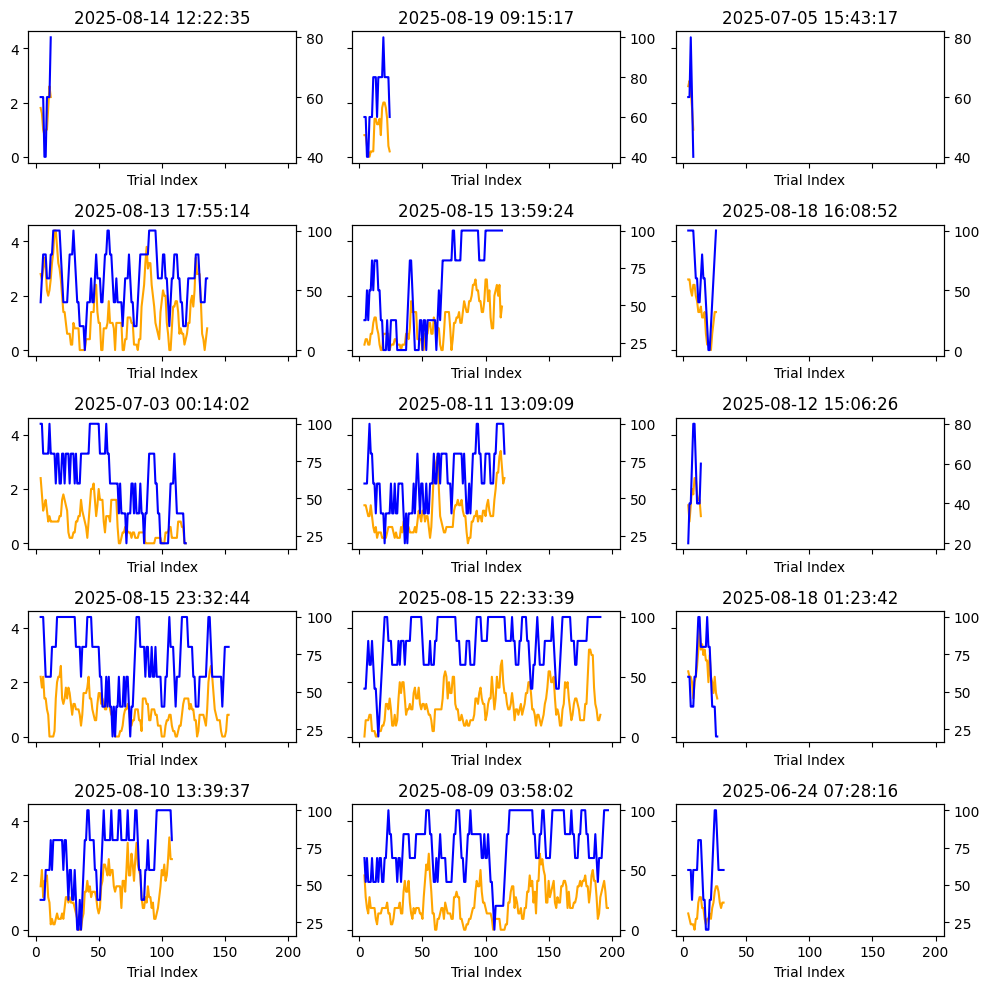

In [68]:
# get sample sessions of the high correlations and plot
random_sessions = corr_df[corr_df.correlation > 0.5].date.sample(15).values
# random_sessions = corr_df[corr_df.correlation < -0.25].date.sample(15).values
fig, axs = plt.subplots(5,3,figsize=(10, 10), sharex=True, sharey=True)
axs = axs.ravel()
for i, random_session in enumerate(random_sessions):
    df_session = df_subset[df_subset.date == random_session]
    axs[i].plot(
        range(len(df_session["fixation_breaks_through_trials"])),
        df_session["fixation_breaks_through_trials"],
        color = 'orange',
        label = 'Fixation Breaks',
        # c=df_session["correct"].map(colors),
    )
    # plot performance in a second y axis
    ax2 = axs[i].twinx()
    ax2.plot(
        range(len(df_session["performance_w"])),
        df_session["performance_w"],
        color = 'blue',
        label = 'Performance',
    )
    axs[i].set_xlabel("Trial Index")
    # axs[i].set_ylabel("Fixation Breaks")
    axs[i].set_title(f"{random_session}")
plt.tight_layout()
plt.show()


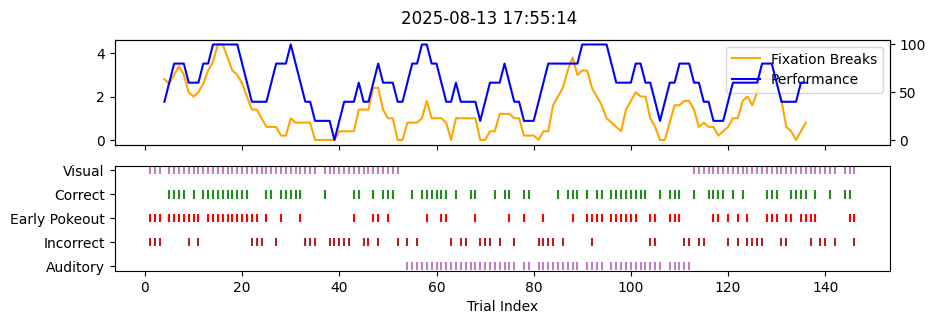

In [89]:
selected_date = '2025-08-13 17:55:14'
df_session = df_subset[df_subset.date == selected_date]
fig, axs = plt.subplots(2,1,figsize=(10, 3), sharex=True)
axs[0].plot(
    range(len(df_session["fixation_breaks_through_trials"])),
    df_session["fixation_breaks_through_trials"],
    color = 'orange',
    label = 'Fixation Breaks',
)
# plot performance in a second y axis
ax2 = axs[0].twinx()
ax2.plot(
    range(len(df_session["performance_w"])),
    df_session["performance_w"],
    color = 'blue',
    label = 'Performance',
)
# set legend
lines, labels = axs[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axs[0].legend(lines + lines2, labels + labels2, loc='upper right')
axs[1].scatter(
    df_session.trial,
    df_session.correct,
    color = df_session.correct.map(colors),
    label = 'Correct',
    marker = '|',
)
axs[1].scatter(
    df_session.trial,
    df_session.stimulus_modality.map({'visual': 1.5, 'auditory': -0.5}),
    color = 'purple',
    label = 'Stimulus Modality',
    marker = '|',
    alpha = 0.5,
)
axs[1].scatter(
    df_session.trial,
    df_session.early_pokeout.map({True: 0.5, False: np.nan}),
    color = 'red',
    label = 'Early Pokeout',
    marker = '|',
)
axs[1].set_xlabel("Trial Index")
axs[1].set_yticks([-0.5, 0, 0.5, 1, 1.5])
axs[1].set_yticklabels(['Auditory', 'Incorrect', 'Early Pokeout', 'Correct', 'Visual'])

plt.suptitle(f"{selected_date}")
plt.show()

The positive correlation indicates that animals are breaking fixation because they are sure about where to go and therefore choose correctly.


It would be interesting to check if this is different during learning, or has any relationship with date (maybe not in a dataframe where animals are already trained)

### Corrections after fixation break that result in an incorrect choice

In [90]:
# how many of the incorrect trials have at least one correct side poke after breaking fixation?
# Focus on only on cases with one fixation break 
it_onebreak_df = df_subset[np.logical_and(
        df_subset.correct==False,
        df_subset.next_event_after_fixation_break_classified.apply(len) == 1
    )]
it_onebreak_df.next_event_after_fixation_break_classified.value_counts()

next_event_after_fixation_break_classified
[incorrect_side]    2827
[center]            2463
[correct_side]      1213
Name: count, dtype: int64

What is the dependency of these "corrections" with the type of stimulus?